In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
Crime_5_7 = pd.read_csv('C:\\Users\\kodur\\Documents\\Chicago_Crimes_2005_to_2007.csv.',
                        na_values = [None, 'NaN','Nothing'], header = 0) 
Crime_8_11 = pd.read_csv('C:\\Users\\kodur\\Documents\\Chicago_Crimes_2008_to_2011.csv.',
                        na_values = [None, 'NaN','Nothing'], header = 0) 
Crime_12_17 = pd.read_csv('C:\\Users\\kodur\\Documents\\Chicago_Crimes_2012_to_2017.csv.',
                        na_values = [None, 'NaN','Nothing'], header = 0)

In [3]:
ZipCode_Data = pd.read_csv('C:\\Users\\kodur\\Documents\\Chicago_Zip_Data.csv.', header = 0)

In [4]:
Crime_Data = [Crime_5_7, Crime_8_11, Crime_12_17]
del Crime_5_7
del Crime_8_11
del Crime_12_17
Crime_Data = pd.concat(Crime_Data,axis = 0)

In [5]:
Crime_Data.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)

In [6]:
Crime_Data.drop(['Unnamed: 0','Case Number','IUCR','FBI Code','Location',
                 'X Coordinate','Y Coordinate','Location'], inplace = True, axis = 1)

In [7]:
Crime_Data.Date = pd.to_datetime(Crime_Data.Date, format = '%m/%d/%Y %I:%M:%S %p')
Crime_Data['Updated On'] = pd.to_datetime(Crime_Data['Updated On'], format = '%m/%d/%Y %I:%M:%S %p')
Crime_Data.index = pd.DatetimeIndex(Crime_Data.Date)

In [8]:
Groups = Crime_Data.groupby(Crime_Data['Primary Type'])
Groups = dict(list(Groups))

In [9]:
#grouping sex crimes together to look into
SexCrimes_Data = [Groups['CRIM SEXUAL ASSAULT'], Groups['HUMAN TRAFFICKING'],
                  Groups['OFFENSE INVOLVING CHILDREN'], Groups['PROSTITUTION'],
                  Groups['SEX OFFENSE'], Groups['STALKING']]
SexCrimes_Data = pd.concat(SexCrimes_Data, axis = 0)
del Groups
del Crime_Data

In [10]:
SexCrimeZipData = pd.read_csv('C:\\Users\\kodur\\Documents\\ChicagoSexCrimesZipCodeData.csv',header = 0)
SexCrimes_Data = SexCrimes_Data.dropna(axis = 0, how = 'any')
SexCrimeZipData.index = pd.DatetimeIndex(SexCrimes_Data.index)

In [11]:
#adding zipcode data
SexCrimes_Data['ZipCode'] = SexCrimeZipData['ZipCode']

In [12]:
#converting data for each zipcode into list zipdata
#recently learned that python is both amazing for memory saving and also really annoying for coding...
G = dict(ZipCode_Data)
keys = list(G.keys())
listdata = []
zipdata = []
for i in range(len(G[keys[0]])):
    for j in range(1,len(keys)):
        listdata.append(G[keys[j]][i])
    listdata = []
    zipdata.append(listdata)

In [13]:
#binary search algorithm to find zip code
def BinarySearch(item, L, data, low, high):
    mid = int(low + (high - low) / 2)
    if (item == L[mid]):
        return data[mid]
    elif (low == high):
        return None
    else:
        if (item < L[mid]):
            return BinarySearch(item, L, data, low, mid - 1)
        else:
            return BinarySearch(item, L, data, mid + 1, high)

In [14]:
SC_Data_Zip = list(SexCrimes_Data.ZipCode)
zdata = [None] * len(SC_Data_Zip)
for i in range(SexCrimeZipData.ZipCode.shape[0]):
    z = BinarySearch(SC_Data_Zip[i], ZipCode_Data.ZipCode, zipdata, 0, 84)
    zdata[i] = z

In [15]:
#creating a data frame, and concatenating the two dataframes
zdata = pd.DataFrame(zdata[:], columns=keys[1:])
zdata.index = SexCrimes_Data.index
Data = [SexCrimes_Data, zdata]
Data = pd.concat(Data, axis = 1)

In [16]:
Data.drop(['ID','Date','Block', 'Updated On','Beat','District','Ward','Community Area'], inplace = True, axis = 1)
Data['Month'] = Data.index.month
Data['Hour'] = Data.index.hour
Data['Day'] = Data.index.day
Data['Minute'] = Data.index.minute
SC_Data = Data.groupby('Primary Type')

In [17]:
#I am going to see if I can isolate any pattern about where the crimes are centered around.
Data_By_Crime = [None] * 6
Data_By_Crime[0] = SC_Data.get_group('CRIM SEXUAL ASSAULT')
Data_By_Crime[1] = SC_Data.get_group('HUMAN TRAFFICKING')
Data_By_Crime[2] = SC_Data.get_group('OFFENSE INVOLVING CHILDREN')
Data_By_Crime[3] = SC_Data.get_group('PROSTITUTION')
Data_By_Crime[4] = SC_Data.get_group('SEX OFFENSE')
Data_By_Crime[5]= SC_Data.get_group('STALKING')

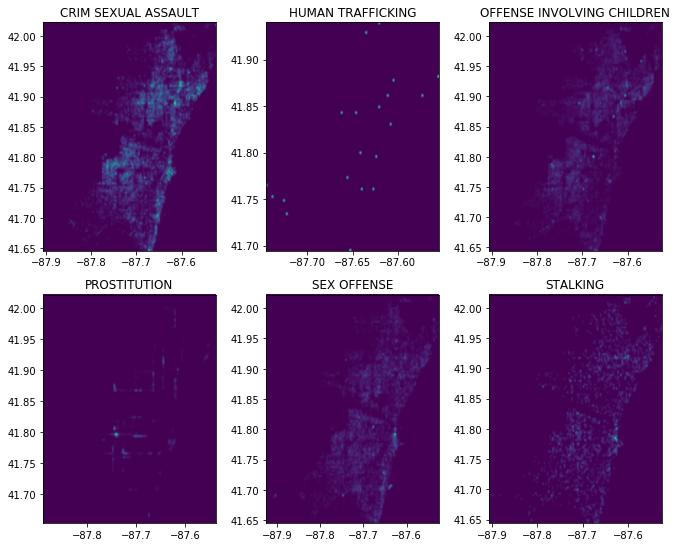

In [18]:
#I will start by using a heatmap to see if there are areas of high concentrations of sex crimes.
#I check how many clusters are most suitable for each class of crime
fig = plt.figure(figsize = (10,8))
d = dict(zip(range(6),Data['Primary Type'].unique()))
plt.axis('off')
for i in range(6):
    Data_By_Crime[i] = Data_By_Crime[i].dropna(how = 'any', axis = 0)
    x = Data_By_Crime[i]['Longitude']
    y = Data_By_Crime[i]['Latitude']
    a = fig.add_subplot(2,3,1+i)
    a.set_title('%s'%d[i])
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=120)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    a.imshow(heatmap.T, extent = extent, aspect = 'auto', interpolation = 'gaussian')
plt.tight_layout()
plt.show()

In [71]:
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
plt.switch_backend('tkagg')
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

In [105]:
#I can  segment by year and see if the clusters are moving/changing in anyway.
#I can then see if there is any overlap between the different sex crime types that I have selected, 
#and if there is, it might mean that the centroids of these clusters are hits for where the crime originates from.
#couldn't figure out how to get them simultaneous, so I just did them all individually instead of in a for loop
Year_Data = Data_By_Crime[0].groupby(['Year'])
YData = []
for j in range(2005,2018):
    for k in range(len(list(Year_Data))):
        if(j == list(Year_Data)[k][0]):
            YData.append(Year_Data.get_group(j))
fig = plt.figure(figsize = (6,5))
listyears = []
for k in range(len(list(Year_Data))):
    listyears.append(list(Year_Data)[k][0])
dyear = dict(zip(range(len(list(Year_Data))),listyears))
ims = []
for j in range(len(YData)):
    YData[j] = YData[j].dropna(how = 'any', axis = 0)
    x = YData[j]['Longitude']
    y = YData[j]['Latitude']
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=100)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = plt.imshow(heatmap.T, extent = extent, cmap = 'hot', aspect = 'auto', interpolation = 'bessel', animated = True)
    plt.title('%s'%d[0])
    ims.append([im])
anim = animation.ArtistAnimation(fig, ims, interval=1000, blit = True)
HTML(anim.to_html5_video())
anim.save('sex_assault.mp4', writer=writer)
plt.show()

In [93]:
Year_Data = Data_By_Crime[1].groupby(['Year'])
YData = []
for j in range(2005,2018):
    for k in range(len(list(Year_Data))):
        if(j == list(Year_Data)[k][0]):
            YData.append(Year_Data.get_group(j))
fig = plt.figure(figsize = (6,4))
listyears = []
for k in range(len(list(Year_Data))):
    listyears.append(list(Year_Data)[k][0])
dyear = dict(zip(range(len(list(Year_Data))),listyears))
ims = []
for j in range(len(YData)):
    YData[j] = YData[j].dropna(how = 'any', axis = 0)
    x = YData[j]['Longitude']
    y = YData[j]['Latitude']
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = plt.imshow(heatmap.T, extent = extent, cmap = 'binary', aspect = 'auto', interpolation = 'nearest', animated = True)
    plt.title('%s'%d[1])
    ims.append([im])
anim = animation.ArtistAnimation(fig, ims, interval=1000, blit = True)
HTML(anim.to_html5_video())
anim.save('human_traff.mp4', writer=writer)
plt.show()

In [101]:
Year_Data = Data_By_Crime[2].groupby(['Year'])
YData = []
for j in range(2005,2018):
    for k in range(len(list(Year_Data))):
        if(j == list(Year_Data)[k][0]):
            YData.append(Year_Data.get_group(j))
fig = plt.figure(figsize = (5,7))
listyears = []
for k in range(len(list(Year_Data))):
    listyears.append(list(Year_Data)[k][0])
dyear = dict(zip(range(len(list(Year_Data))),listyears))
ims = []
for j in range(len(YData)):
    YData[j] = YData[j].dropna(how = 'any', axis = 0)
    x = YData[j]['Longitude']
    y = YData[j]['Latitude']
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=200)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = plt.imshow(heatmap.T, extent = extent, cmap = 'hot', aspect = 'auto', interpolation = 'nearest', animated = True)
    plt.title('%s'%d[2])
    ims.append([im])
anim = animation.ArtistAnimation(fig, ims, interval=1000, blit = True)
HTML(anim.to_html5_video())
anim.save('child_offenses.mp4', writer=writer)
plt.show()

In [100]:
Year_Data = Data_By_Crime[3].groupby(['Year'])
YData = []
for j in range(2005,2018):
    for k in range(len(list(Year_Data))):
        if(j == list(Year_Data)[k][0]):
            YData.append(Year_Data.get_group(j))
fig = plt.figure(figsize = (7,5))
listyears = []
for k in range(len(list(Year_Data))):
    listyears.append(list(Year_Data)[k][0])
dyear = dict(zip(range(len(list(Year_Data))),listyears))
ims = []
for j in range(len(YData)):
    YData[j] = YData[j].dropna(how = 'any', axis = 0)
    x = YData[j]['Longitude']
    y = YData[j]['Latitude']
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=120)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = plt.imshow(heatmap.T, extent = extent, cmap = 'hot', aspect = 'auto', interpolation = 'hamming', animated = True)
    plt.title('%s'%d[3])
    ims.append([im])
anim = animation.ArtistAnimation(fig, ims, interval=1000, blit = True)
HTML(anim.to_html5_video())
anim.save('prostitution.mp4', writer=writer)
plt.show()

In [110]:
Year_Data = Data_By_Crime[4].groupby(['Year'])
YData = []
for j in range(2005,2018):
    for k in range(len(list(Year_Data))):
        if(j == list(Year_Data)[k][0]):
            YData.append(Year_Data.get_group(j))
fig = plt.figure(figsize = (5,5))
listyears = []
for k in range(len(list(Year_Data))):
    listyears.append(list(Year_Data)[k][0])
dyear = dict(zip(range(len(list(Year_Data))),listyears))
ims = []
for j in range(len(YData)):
    YData[j] = YData[j].dropna(how = 'any', axis = 0)
    x = YData[j]['Longitude']
    y = YData[j]['Latitude']
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=100)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = plt.imshow(heatmap.T, extent = extent, cmap = 'hot', aspect = 'auto', interpolation = 'bessel', animated = True)
    plt.title('%s'%d[4])
    ims.append([im])
anim = animation.ArtistAnimation(fig, ims, interval=1000, blit = True)
HTML(anim.to_html5_video())
anim.save('sex_offenses.mp4', writer=writer)
plt.show()

In [109]:
Year_Data = Data_By_Crime[5].groupby(['Year'])
YData = []
for j in range(2005,2018):
    for k in range(len(list(Year_Data))):
        if(j == list(Year_Data)[k][0]):
            YData.append(Year_Data.get_group(j))
fig = plt.figure(figsize = (5,5))
listyears = []
for k in range(len(list(Year_Data))):
    listyears.append(list(Year_Data)[k][0])
dyear = dict(zip(range(len(list(Year_Data))),listyears))
ims = []
for j in range(len(YData)):
    YData[j] = YData[j].dropna(how = 'any', axis = 0)
    x = YData[j]['Longitude']
    y = YData[j]['Latitude']
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=100)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = plt.imshow(heatmap.T, extent = extent, cmap = 'hot', aspect = 'auto', interpolation = 'bessel', animated = True)
    plt.title('%s'%d[5])
    ims.append([im])
anim = animation.ArtistAnimation(fig, ims, interval=1000, blit = True)
HTML(anim.to_html5_video())
anim.save('stalking.mp4', writer=writer)
plt.show()

In [111]:
%matplotlib inline

In [ ]:
#In the previous part, I tried to see if there was any way to discern whether an arrest would be made or not;
#therefore, in this one I will also try to do that given the new information about the zip code data.
#One of the things I will be looking for is if there is any relationship between sex trafficking and the other crimes
#after a few years have passed.